In [2]:
"""
Some file paths need to be changed here cuz I was lazy and hard coded them 

for the image dataset for viewing the bounding boxes in relation to the images
image_path = '/path/to/kitti/dataset/data_tracking_image_2/training/image_02/0018/000'+str(image+img_offset+1)+'.png'

the lane detection data - I can push this up if needed?
lane_file = 'path/to/lane/data/inf_data.json'


"""

"\nSome file paths need to be changed here cuz I was lazy and hard coded them \n\nfor the image dataset for viewing the bounding boxes in relation to the images\nimage_path = '/path/to/kitti/dataset/data_tracking_image_2/training/image_02/0018/000'+str(image+img_offset+1)+'.png'\n\nthe lane detection data - I can push this up if needed?\nlane_file = 'path/to/lane/data/inf_data.json'\n\n\n"

In [3]:
from keras.models import Sequential
from keras.layers.convolutional import Conv3D
from keras.layers.convolutional_recurrent import ConvLSTM2D
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.callbacks import EarlyStopping
import numpy as np
import cv2 

import pylab as plt
from matplotlib.pyplot import figure
import tensorflow as tf
from sklearn.preprocessing import normalize, scale, StandardScaler
import os,glob
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error
from math import sqrt
import json
from statistics import mode
from pathlib import Path

Using TensorFlow backend.


In [4]:
def evaluate_forecasts(actual, predicted):
    scores = list()
    # calculate an RMSE score for each day
    for i in range(actual.shape[1]):
        # calculate mse
        #print(actual[:, i])
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        # calculate rmse
        rmse = sqrt(mse)
        # store
        scores.append(rmse)
    # calculate overall RMSE
    s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    print(actual.shape)
    score = sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score, scores

In [5]:
folder_path = 'label_02'
file_list = glob.glob(os.path.join(folder_path, '*.txt'))
data = []
for input_file in file_list:
    input_data = {}
    with open(input_file, 'r') as data_stream:
        for line in data_stream:
            current_line = line.split(' ')
            if not (('DontCare' in current_line[2]) or ('Pedestrian' in current_line[2]) or 
                    ('Cyclist' in current_line[2])):
                if (current_line[2]+ current_line[1]) in input_data.keys():
                    #key by object and unique identifier e.g. Car1
                    input_data[current_line[2] + current_line[1]].append({'frame': current_line[0], 
                         'bbox': current_line[6:10]})
                else:
                    input_data[current_line[2] + current_line[1]] = [{'frame': current_line[0], 
                         'bbox': current_line[6:10]}]
    if len(input_data.keys()) > 20:
        print(input_file)
        data.append(input_data)

label_02/0007.txt
label_02/0010.txt
label_02/0004.txt
label_02/0005.txt
label_02/0011.txt
label_02/0001.txt
label_02/0019.txt
label_02/0018.txt
label_02/0020.txt
label_02/0008.txt
label_02/0009.txt


In [6]:
sequence_list = []
lane_test_sequence = []
lane_frames = []
i = 0
for sequence in data:
    frame_dict = {}
    lane_frame_dict = {}
    for unique_object in sequence:
        if len(sequence[unique_object]) > 99:
            #if i == 7:
                
                #print(unique_object)
            
            for frame in sequence[unique_object]:
                if frame['frame'] in frame_dict.keys():
                    frame_dict[frame['frame']].append(frame['bbox'])                
                else:
                    frame_dict[frame['frame']] = [frame['bbox']]
                
                
                if i == 7 and frame['frame'] in lane_frame_dict.keys():
                    if unique_object in ['Car2', 'Car3', 'Car6']:
                        lane_frame_dict[frame['frame']].append(frame['bbox'])
                elif i == 7:
                    if i == 7 and unique_object in ['Car2', 'Car3', 'Car6']:
                        lane_frame_dict[frame['frame']] = [frame['bbox']]
                
                
                #print(frame)
    frame_sample_dict = {}
    for frame in frame_dict:
        if len(frame_dict[frame]) > 2:
            if len(frame_sample_dict) < 150:
                frame_sample_dict[frame] = frame_dict[frame][:3]
    if len(frame_sample_dict) == 150:
        sequence_list.append(frame_sample_dict)
        print(i)
    #print(frame_sample_dict)
    lane_frame_sample_dict = {}
    if i == 7:
        for j in range(226-57, 326 + 10):
            if len(lane_frame_dict[str(j)]) >= 3:
                lane_frames.append(j)
                lane_frame_sample_dict[str(j)] = lane_frame_dict[str(j)][:3]
        #print(frame_dict['226'])
        lane_test_sequence.append(lane_frame_sample_dict)
    i += 1
            #print(sequence[unique_object])
               
np.array(sequence_list).shape

4
6
7
8
9


(5,)

In [7]:
lane_frames

[169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185,
 186,
 187,
 188,
 189,
 190,
 191,
 192,
 193,
 194,
 195,
 196,
 197,
 198,
 199,
 200,
 201,
 202,
 203,
 204,
 205,
 206,
 207,
 208,
 209,
 210,
 211,
 212,
 213,
 214,
 215,
 216,
 217,
 218,
 219,
 220,
 221,
 222,
 223,
 224,
 225,
 226,
 227,
 228,
 229,
 230,
 231,
 232,
 233,
 234,
 235,
 236,
 237,
 238,
 239,
 240,
 241,
 242,
 243,
 244,
 245,
 246,
 247,
 248,
 249,
 250,
 251,
 252,
 253,
 254,
 255,
 256,
 257,
 258,
 259,
 260,
 261,
 262,
 263,
 264,
 265,
 266,
 267,
 268,
 269,
 270,
 271,
 272,
 273,
 274,
 275,
 276,
 277,
 278,
 279,
 280,
 281,
 282,
 283,
 284,
 285,
 286,
 287,
 288,
 289,
 290,
 291,
 292,
 293,
 294,
 295,
 296,
 297,
 298,
 299,
 300,
 301,
 302,
 303,
 304,
 305,
 306,
 307,
 308,
 309,
 310,
 311,
 312,
 313,
 314,
 315,
 316,
 317,
 318]

In [8]:
X = []
y = []
list_lengths = []
for sequence in sequence_list:
    sequence_of_frames = []
    for frame in sequence:
        #print(sequence[frame])
        frame_list = []
        for tuples in sequence[frame]:
            #print(tuples)
            frame_list.append(tuples[0])
            frame_list.append(tuples[1])
            frame_list.append(tuples[2])
            frame_list.append(tuples[3])
        #print('***')
        #print(frame_list)
        #print('***')
        #print(len(frame_list))
        sequence_of_frames.append(frame_list)
        #print(np.array((sequence_of_frames)).shape)
    X.append(sequence_of_frames)
    y.append(sequence_of_frames)
    #print(sequence.keys())
X = np.array(X)
y = np.array(y)

In [9]:
ynorm1 = np.zeros(y.shape)

sample_list = []
for sample in range(0,X.shape[0]):
    list_0 = []
    list_1 = []
    list_2 = []
    list_3 = []
    list_4 = []
    list_5 = []
    list_6 = []
    list_7 = []
    list_8 = []
    list_9 = []
    list_10 = []
    list_11 = []
    for clip in range(0, X.shape[1]):
        clip_list = []
        list_0.append(X[sample, clip, 0])
        list_1.append(X[sample, clip, 1])
        list_2.append(X[sample, clip, 2])
        list_3.append(X[sample, clip, 3])
        list_4.append(X[sample, clip, 4])
        list_5.append(X[sample, clip, 5])
        list_6.append(X[sample, clip, 6])
        list_7.append(X[sample, clip, 7])
        list_8.append(X[sample, clip, 8])
        list_9.append(X[sample, clip, 9])
        list_10.append(X[sample, clip, 10])
        list_11.append(X[sample, clip, 11])
    sample_list.append([list_0, list_1, list_2, list_3, list_4, list_5, list_6, list_7, list_8, list_9, list_10, list_11])
sample_list = np.array(sample_list).astype(np.float)
ynorm1 = np.zeros(sample_list.shape)
y_minmax = np.zeros((sample_list.shape[0], sample_list.shape[1], 2))
for sample in range(0, sample_list.shape[0]):
    for clip in range(0, sample_list.shape[1]):
        y_min = np.amin(sample_list[sample, clip])
        y_max = np.amax(sample_list[sample, clip])
        y_minmax[sample, clip, 0] = y_min
        y_minmax[sample, clip, 1] = y_max
        for value in range(0, sample_list.shape[2]):
            ynorm1[sample, clip, value] = (float(sample_list[sample, clip, value]) - y_min)/(y_max - y_min)
y_new = np.zeros(y.shape)
for sample in range(0, len(ynorm1)):
    for sets in  range(0, len(ynorm1[0])):
        for frame_value in range(0, len(ynorm1[0][0])):
            y_new[sample, frame_value, sets] = ynorm1[sample, sets, frame_value]
            

In [10]:
Xtr = np.array(y_new[:4, :30, :])
Xtr = np.append(Xtr, y_new[:4, 30:60, :], axis=0)
Xtr = np.append(Xtr, y_new[:4, 60:90, :], axis=0)
Xtr = np.append(Xtr, y_new[:4, 90:120, :], axis=0)

ytr = np.array(y_new[:4, 30:60, :])
ytr = np.append(ytr, y_new[:4, 60:90, :], axis=0)
ytr = np.append(ytr, y_new[:4, 90:120, :], axis=0)
ytr = np.append(ytr, y_new[:4, 120:150, :], axis=0)

Xte = np.array(y_new[4:, :30, :])
Xte = np.append(Xte, y_new[4:, 30:60, :], axis=0)
Xte = np.append(Xte, y_new[4:, 60:90, :], axis=0)
Xte = np.append(Xte, y_new[4:, 90:120, :], axis=0)

yte = np.array(y_new[4:, 30:60, :])
yte = np.append(yte, y_new[4:, 60:90, :], axis=0)
yte = np.append(yte, y_new[4:, 90:120, :], axis=0)
yte = np.append(yte, y_new[4:, 120:150, :], axis=0)

In [11]:
Xtr.shape

(16, 30, 12)

In [12]:
es = EarlyStopping(monitor='val_loss', mode='min', patience=10)

In [13]:
modelItem = Sequential()
modelItem.add(LSTM(32, return_sequences = True,input_shape=(30, 12), activation='relu'))
modelItem.add(Dropout(0.4))

modelItem.add(LSTM(units = 24, return_sequences = True, activation='relu'))
modelItem.add(Dropout(0.4))

# modelItem.add(LSTM(units = 24, return_sequences = True, activation='relu'))
# modelItem.add(Dropout(0.4))


modelItem.add(Dense(12))
modelItem.compile(optimizer='adam', loss='mse')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [14]:
history = modelItem.fit(Xtr, ytr, epochs=75, validation_split=0.2, verbose=1)


Train on 12 samples, validate on 4 samples
Epoch 1/75
12/12 [==============================] - 2s 181ms/step - loss: 0.3560 - val_loss: 0.2635
Epoch 2/75
12/12 [==============================] - 0s 5ms/step - loss: 0.3494 - val_loss: 0.2617
Epoch 3/75
12/12 [==============================] - 0s 4ms/step - loss: 0.3460 - val_loss: 0.2598
Epoch 4/75
12/12 [==============================] - 0s 4ms/step - loss: 0.3410 - val_loss: 0.2581
Epoch 5/75
12/12 [==============================] - 0s 4ms/step - loss: 0.3361 - val_loss: 0.2562
Epoch 6/75
12/12 [==============================] - 0s 4ms/step - loss: 0.3324 - val_loss: 0.2544
Epoch 7/75
12/12 [==============================] - 0s 4ms/step - loss: 0.3270 - val_loss: 0.2524
Epoch 8/75
12/12 [==============================] - 0s 4ms/step - loss: 0.3233 - val_loss: 0.2504
Epoch 9/75
12/12 [==============================] - 0s 5ms/step - loss: 0.3207 - val_loss: 0.2481
Epoch 10/75
12/12 [==============================] - 0s 5ms/step - loss:

In [15]:
predictions = modelItem.predict(Xte, verbose=0)

In [16]:
predictions.shape

(4, 30, 12)

In [17]:
predictions = predictions.reshape(1,120,12)
yte = yte.reshape(1,120,12)

In [18]:
predictions.shape

(1, 120, 12)

In [19]:
evaluate_forecasts(yte[0], predictions[0])

(120, 12)


(0.33805592709648763,
 [0.4661755203661521,
  0.3410368671138397,
  0.41161713521991267,
  0.42868713838975886,
  0.312124910141558,
  0.31452112505513685,
  0.2926532467370049,
  0.28456955898720987,
  0.34015281345620585,
  0.19979821958348593,
  0.32302065308018635,
  0.24822926350836108])

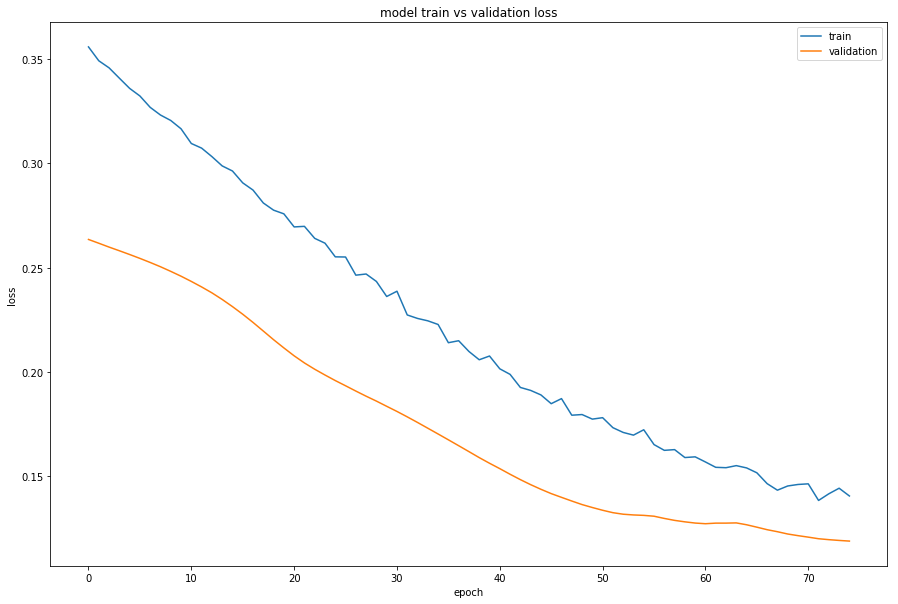

In [20]:
plt.rcParams["figure.figsize"]=15, 10
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

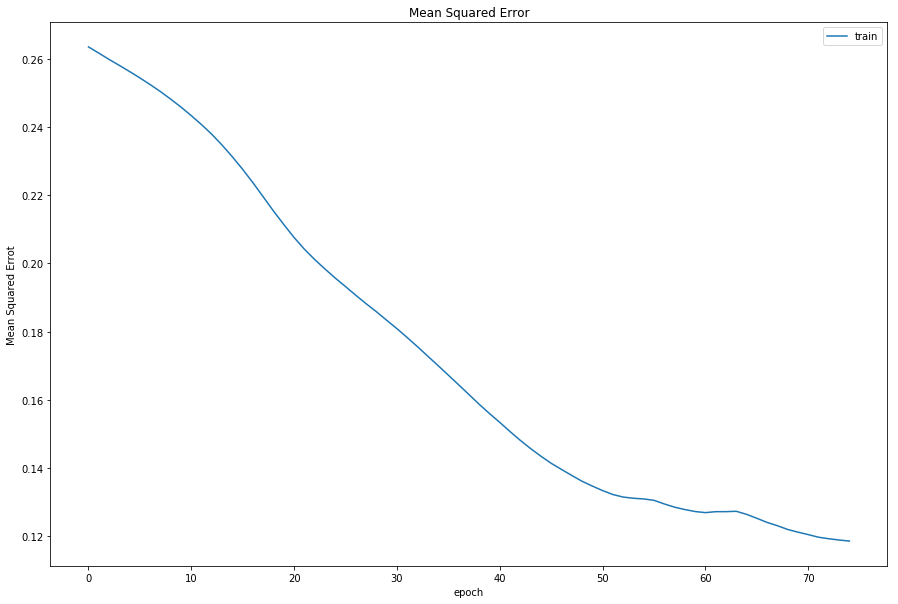

In [21]:
#pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('Mean Squared Error')
pyplot.ylabel('Mean Squared Errot')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

In [22]:
lane_file = os.path.join(os.path.split(Path.cwd())[0], 'Images/JSON/inf_data.json')

In [23]:
lane_data = []
with open(lane_file) as f:
    for line in f:
        if line:
            lane_data.append(json.loads(line))

In [24]:
lane_curves = {}
for image in lane_data:
    for key in image:
        llist = []
        h_samples_list = []
        for i in range(0,len(image[key]['lanes'])):
            llist = []
            if image[key]['lanes'][i]:
                llist = image[key]['lanes'][i]

                hlist = image[key]['h_samples'][i]
                curve_coeffs = np.polyfit(np.array(llist), np.array(hlist), 2)
                y = np.linspace(np.amin(llist),np.amax(llist))
                if key in lane_curves.keys():
                    lane_curves[key].append(((curve_coeffs[0] * y ** 2+ curve_coeffs[1] * y + curve_coeffs[2]), y))
                else:
                    lane_curves[key] = [((curve_coeffs[0] * y ** 2+ curve_coeffs[1] * y + curve_coeffs[2]), y)]
dummy_counter = 0
for key in lane_curves.keys():
    for lane in range(0, len(lane_curves[key])):
        try:
            if lane_curves[key][lane][1][-1] < lane_curves[key][lane+1][1][-1]:
                dummy = lane_curves[key][lane+1]
                lane_curves[key][lane+1] = lane_curves[key][lane]
                lane_curves[key][lane] = dummy
        except:
            dummy_counter +=1

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


In [25]:
pred_norm = np.zeros(predictions.shape)
yte_norm = np.zeros(yte.shape)

for sample in range(0,predictions.shape[0]):
    for clip in range(0, predictions.shape[1]):
        for value in range(0, predictions.shape[2]):
            #print(predictions[sample, clip, value])
            pred_norm[sample, clip, value] = (predictions[sample, clip, value ] * (y_minmax[sample, value, 1] - y_minmax[sample, value, 0])) + y_minmax[sample, value, 0]
            yte_norm[sample, clip, value] = (yte[sample, clip , value ] * (y_minmax[sample, value, 1] - y_minmax[sample, value, 0])) + y_minmax[sample, value, 0]




In [26]:
# File Numbers 
#use file 8 for number 20/21
#file No.  File     image offset
#  0  label_02/0007.txt    39
#  1  label_02/0010.txt    66
#  2  label_02/0004.txt     2
#  3  label_02/0005.txt    26
#  4  label_02/0011.txt     0     145
#  5  label_02/0001.txt     0
#  6  label_02/0019.txt   192     553
#  7  label_02/0018.txt    68      68
#  8  label_02/0020.txt     0       0
#  9  label_02/0008.txt    11     158      240  - 389
#  10 label_02/0009.txt     7

In [27]:
yte_centre = []
for sequence in yte_norm:
    centre_list = []
    for tuples in sequence:
        obj_1_centre = ((tuples[2] + tuples[0])/2, (tuples[3] + tuples[1])/2)
        obj_2_centre = ((tuples[6] + tuples[4])/2, (tuples[7] + tuples[5])/2)
        obj_3_centre = ((tuples[10] + tuples[8])/2, (tuples[11] + tuples[9])/2)
        centre_list.append((obj_1_centre, obj_2_centre, obj_3_centre))
    yte_centre.append(centre_list)

In [28]:
pred_centre = []
for sequence in pred_norm:
    centre_list = []
    for tuples in sequence:
        obj_1_centre = ((tuples[2] + tuples[0])/2, (tuples[3] + tuples[1])/2)
        obj_2_centre = ((tuples[6] + tuples[4])/2, (tuples[7] + tuples[5])/2)
        obj_3_centre = ((tuples[10] + tuples[8])/2, (tuples[11] + tuples[9])/2)
        centre_list.append((obj_1_centre, obj_2_centre, obj_3_centre))
    pred_centre.append(centre_list)

In [29]:
print(Path.cwd())

/Users/Tarun/Desktop/4thYearProject/KittiLSTM


not working
not working
not working
not working
not working
225


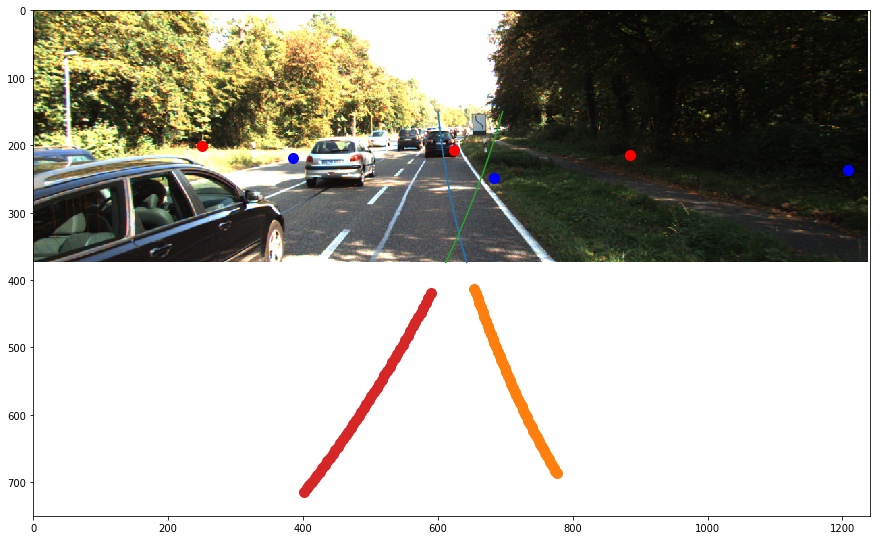

226


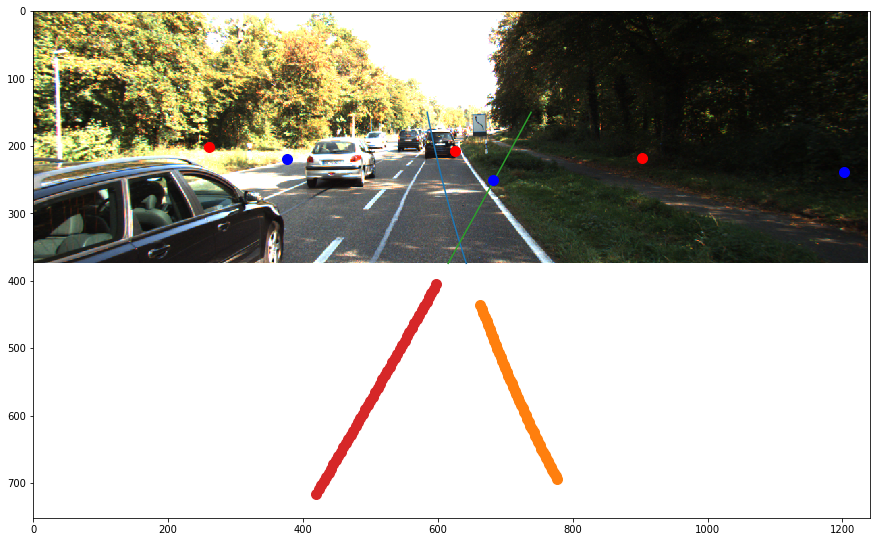

not working
not working
not working


In [30]:
plt.rcParams["figure.figsize"]=15, 90
for image_index in range(0, 10):
    image = lane_frames[image_index+50]
    if '000'+str(image+1)+'.png' in lane_curves.keys():
        print(image+1)
        file = 0
        image_path = '/Users/Tarun/Desktop/data_tracking_image_2/training/image_02/0018/000'+str(image+1)+'.png'
        image_file= cv2.imread(image_path, cv2.IMREAD_COLOR)
        plt.imshow(image_file[:, :, (2, 1, 0)])    
        for i in range(0, len(lane_curves['000'+str(image+1)+'.png'])):
            curve_points = np.polyfit(lane_curves['000'+str(image+1)+'.png'][i][0], lane_curves['000'+str(image+1)+'.png'][i][1], 2)
            y = np.linspace(150, image_file.shape[0])
            x = curve_points[0] * y ** 2 + curve_points[1] * y + curve_points[2]
            plt.plot(x, y)
            plt.plot(lane_curves['000'+str(image+1)+'.png'][i][1], lane_curves['000'+str(image+1)+'.png'][i][0], 'o', markersize=10)
            

        plt.plot(pred_centre[0][image_index][0][0],pred_centre[0][image_index][0][1], 'or', markersize=10)
        plt.plot(pred_centre[0][image_index][1][0],pred_centre[0][image_index][1][1], 'or', markersize=10)
        plt.plot(pred_centre[0][image_index][2][0],pred_centre[0][image_index][2][1], 'or', markersize=10)


        plt.plot(yte_centre[0][image_index][0][0],yte_centre[0][image_index][0][1], 'ob', markersize=10)
        plt.plot(yte_centre[0][image_index][1][0],yte_centre[0][image_index][1][1], 'ob', markersize=10)
        plt.plot(yte_centre[0][image_index][2][0],yte_centre[0][image_index][2][1], 'ob', markersize=10)
        
        plt.rcParams["figure.figsize"]=15, 10
        plt.xlim(0, 1241)



        plt.show()
    else: 
        print('not working')

plt.rcParams["figure.figsize"]=3,2


In [31]:
def get_vector(A,B):
    return ((A[0] - A[1]), (B[0] - B[1]))

In [32]:

obj_states = [0, 0, 0]
obj_changes = []
lane_changed_obj = []
image_offest = int(sorted(lane_curves.keys())[0].split('.')[0])


for object_pairs in pred_centre[0]:
    for object_centre in object_pairs:
        current_obj = object_pairs.index(object_centre)
        object_region = obj_states[current_obj]
        current_obj_state = object_region
        for key in lane_curves.keys():
            current_lane = list(lane_curves.keys()).index(key)            
            if ('000' + str(pred_centre[0].index(object_pairs)+ image_offest) + '.') in key:
                current_state = 0
                lane_quart_points = []
                for i in range(0, len(lane_curves[key])):
                    xquart = lane_curves[key][i][1][0]
                    lane_quart_points.append(xquart)

                for quart_point in lane_quart_points:
                    if (object_centre[0] < quart_point) and quart_point - 60 < object_centre[0]:
                        current_state += 1                
                if (current_state) != object_region:
                    obj_changes.append((key, current_obj))
                    obj_states[current_obj] = current_state
        
        if len(obj_changes) > 3:
            if obj_changes[-1][1] == obj_changes[-2][1]:
                if (obj_changes[-2], obj_changes[-1]) not in lane_changed_obj:
                    if int((obj_changes[-3][0]).split('.')[0]) + 10 >= int((obj_changes[-2][0]).split('.')[0]):
                        lane_changed_obj.append((obj_changes[-2], obj_changes[-1]))
obj_count = []
for pairs in lane_changed_obj:
    obj_count.append(pairs[0][1])
 
    
print('Lane change occuring from: ' + lane_changed_obj[0][0][0] + ' -> '+ lane_changed_obj[-1][1][0])  
print('Object: ' + str(mode(obj_count)))

Lane change occuring from: 000041.png -> 000126.png
Object: 1


In [98]:
"""
# serialize model to JSON
model_json = modelItem.to_json()
with open("modelacc.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
modelItem.save_weights("modelacc.h5")
print("Saved model to disk")

SyntaxError: EOF while scanning triple-quoted string literal (<ipython-input-98-c5b645e5d616>, line 8)